In [1]:
import cupy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gzip
import os
import re
import transformers
import torch

from collections import Counter, defaultdict
from utils import *

%matplotlib inline

In [2]:
PATH = './data/'
files = os.listdir(PATH)
if len(files) == 1:
    print('Single file in data folder.')
    file = PATH + ' '.join(files)
    print('File: {}'.format(file))
elif len(files) > 1:
    print('Multiple files in data folder.')
    files = list(map(lambda file: PATH + file, files))
    print(files)
else:
    raise Exception('There are no files in data folder.')

Single file in data folder.
File: ./data/grocery.tar


In [4]:
subjqa = pd.read_csv(file)

In [5]:
cols = ['question', 'review', 'human_ans_spans']

In [26]:
for i, row in subjqa.iterrows():
    for col in cols:
        if col == 'review':
            text = row[col][:row[col].index('ANSWERNOTFOUND')].strip()
        else:
            text = row[col].strip()
        print(col + ': {}'.format(text))
    print()
    if i == 10: break

question: How is water?
review: The ALOE GLOE Natural Aloe Water drinking water has a noticeably distinct taste compared to the regular bottled ones you buy in the store. And I say this from a bottled-water drinker perspective. Water in my part of the country is specially hard, even when applying consumer filtration. That is why we have regular drinking water delivery. But after trying ALOE GLOE, I have a brand new perspective of what drinking water should be. Nothing beats water that is organic and contains the right minerals and ph balance. It is also gluten-free which is good for people who is intolerant of gluten. Unlike other consumer grade bottled drinking water, the ALOE GLOE is organic, free of any preservatives. This a truly long lasting hydrating liquid is that it is infused with electrolytes and life essential minerals that you cannot get with consumer-grade bottled water. ALOE GLOE hydrates better making drinking water fun and far in between. Very highly recommended!!
human

review: This is NOT your usual type of tea. I do not think this actually qualifies to be called a "tea"in the real sense of the word. I doubt if the sachets contain much by way of actual tea leaves at all. So don't expect the usual flavored tea. This is more like a brew of actual garden vegetables. The taste of the vegetables is clearly defined and strong. It has a taste similar to what you will get if you drink the water of boiled vegetables. Not many people will like that. I would call this a vegetable brew rather than a tea. I like it, but not for an every day drink. Just for once in a while when i want to shock my taste buds.
human_ans_spans: ANSWERNOTFOUND

question: How was the sauce?
review: We've had this on chicken, pork ribs and as a dipping sauce for some cheap chicken nuggets and it was good with all of them. For a habanero sauce this is actually quite mild and the ginger aspect of it is more of an aftertaste than a prominent flavor.All in all it is well done. My only gripe

In [6]:
descriptive_stats(subjqa, cols)

{'avg_question_length': 5.447032967032967,
 'avg_review_length': 162.1846153846154,
 'avg_human_ans_spans_length': 3.8540659340659342}

In [7]:
subjqa.loc[:, 'does_the_answer_span_you_selected_expresses_a_subjective_opinion_or_an_objective_measurable_fact'].unique()

array(['1', '5', '2', '4', '3',
       'does_the_answer_span_you_selected_expresses_a_subjective_opinion_or_an_objective_measurable_fact',
       nan], dtype=object)

In [8]:
subj_levels_ans_key = 'does_the_answer_span_you_selected_expresses_a_subjective_opinion_or_an_objective_measurable_fact'
subj_levels_q_key = 'question_subj_level'
subj_levels_ans_frq = Counter(subjqa.loc[:, subj_levels_ans_key].values)
subj_levels_q_frq = Counter(subjqa.loc[:, subj_levels_q_key].values)

In [9]:
likert_scale = [str(i) for i in range(1, 6)]

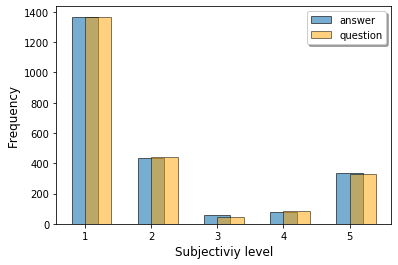

In [11]:
subj_levels_ans = filter_sbj_levels(subj_levels_ans_frq, likert_scale)
subj_levels_q = filter_sbj_levels(subj_levels_q_frq, likert_scale)

e = 2e-1
plt.bar(list(range(1, 6)), [subj_levels_ans[level] for level in likert_scale], width=0.4, alpha=0.6, edgecolor='black', label='answer')
plt.bar(np.array(list(range(1, 6))) + e, [subj_levels_q[level] for level in likert_scale], width=0.4, alpha=0.5, edgecolor='black', color='orange', label='question')
plt.xlabel('Subjectiviy level', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fancybox=True, shadow=True)
plt.show()